# Introduction
This notebook show the work done on the AUTO Insurance Dataset. 

# Plan
- Cleaning the Dataset
- Visualisation
- Prédiction
- Explicabilité

In [116]:
#Import

import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression

import numpy as np
import lime
from lime import lime_tabular

In [117]:
train_dataset = pd.read_csv(r"data/auto-insurance-fall-2017/train_auto.csv",
    index_col='INDEX',
    false_values=['no', 'No', 'NO', 'z_No'],
    true_values=['yes', 'Yes', 'YES'],)
test_dataset = pd.read_csv(r"data/auto-insurance-fall-2017/test_auto.csv",
    index_col='INDEX',
    false_values=['no', 'No', 'NO', 'z_No'],
    true_values=['yes', 'Yes', 'YES'],) 
    

In [118]:
train_dataset.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",False,$0,False,...,"$14,230",11,Minivan,True,"$4,461",2,False,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",False,"$257,252",False,...,"$14,940",1,Minivan,True,$0,0,False,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",False,"$124,191",True,...,"$4,010",4,z_SUV,False,"$38,690",2,False,3,10.0,Highly Urban/ Urban
5,0,0.0,0,51.0,0,14.0,NaN,False,"$306,251",True,...,"$15,440",7,Minivan,True,$0,0,False,0,6.0,Highly Urban/ Urban
6,0,0.0,0,50.0,0,NaN,"$114,986",False,"$243,925",True,...,"$18,000",1,z_SUV,False,"$19,217",2,True,3,17.0,Highly Urban/ Urban


In [119]:
for caracter in ["$","z_",","]:
    train_dataset = train_dataset.apply(lambda x: x.str.replace(caracter, '') if x.dtype == object else x)
    test_dataset = test_dataset.apply(lambda x: x.str.replace(caracter, '') if x.dtype == object else x)

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [120]:
# We change the features as a str with a dollar sign as a string to a float.
dollar_features = ["INCOME", "HOME_VAL", "BLUEBOOK", "OLDCLAIM"]
train_dataset[dollar_features]=train_dataset[dollar_features].astype('float')
test_dataset[dollar_features]=test_dataset[dollar_features].astype('float')

categorical_features = ["SEX","EDUCATION","JOB","CAR_USE","CAR_TYPE","URBANICITY"]
train_dataset[categorical_features]=train_dataset[categorical_features].astype('category')
test_dataset[categorical_features]=test_dataset[categorical_features].astype('category')



In [121]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   TARGET_FLAG  8161 non-null   int64   
 1   TARGET_AMT   8161 non-null   float64 
 2   KIDSDRIV     8161 non-null   int64   
 3   AGE          8155 non-null   float64 
 4   HOMEKIDS     8161 non-null   int64   
 5   YOJ          7707 non-null   float64 
 6   INCOME       7716 non-null   float64 
 7   PARENT1      8161 non-null   bool    
 8   HOME_VAL     7697 non-null   float64 
 9   MSTATUS      8161 non-null   bool    
 10  SEX          8161 non-null   category
 11  EDUCATION    8161 non-null   category
 12  JOB          7635 non-null   category
 13  TRAVTIME     8161 non-null   int64   
 14  CAR_USE      8161 non-null   category
 15  BLUEBOOK     8161 non-null   float64 
 16  TIF          8161 non-null   int64   
 17  CAR_TYPE     8161 non-null   category
 18  RED_CAR      8161 non-null 

In [122]:
train_dataset.describe()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,CLM_FREQ,MVR_PTS,CAR_AGE
count,8161.000000,8161.000000,8161.000000,8155.000000,8161.000000,7707.000000,7716.000000,7697.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,8161.000000,7651.000000
mean,0.263816,1504.324648,0.171057,44.790313,0.721235,10.499286,61898.094609,154867.289723,33.485725,15709.899522,5.351305,4037.076216,0.798554,1.695503,8.328323
std,0.440728,4704.026930,0.511534,8.627589,1.116323,4.092474,47572.682808,129123.774574,15.908333,8419.734075,4.146635,8777.139104,1.158453,2.147112,5.700742
min,0.000000,0.000000,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1500.000000,1.000000,0.000000,0.000000,0.000000,-3.000000
25%,0.000000,0.000000,0.000000,39.000000,0.000000,9.000000,28097.000000,0.000000,22.000000,9280.000000,1.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,45.000000,0.000000,11.000000,54028.000000,161160.000000,33.000000,14440.000000,4.000000,0.000000,0.000000,1.000000,8.000000
75%,1.000000,1036.000000,0.000000,51.000000,1.000000,13.000000,85986.000000,238724.000000,44.000000,20850.000000,7.000000,4636.000000,2.000000,3.000000,12.000000
max,1.000000,107586.136160,4.000000,81.000000,5.000000,23.000000,367030.000000,885282.000000,142.000000,69740.000000,25.000000,57037.000000,5.000000,13.000000,28.000000


The value "CAR_AGE" has a negative minimum (-3).  

## Dealing with categorical features

In [123]:
features = list(train_dataset.columns)
target = "TARGET_FLAG"
features.remove(target)
features.remove("TARGET_AMT")
numerical_features = [feat for feat in features if not feat in categorical_features]
# We check that all the data have a value for TARGET_FLAG.
assert train_dataset[target].isna().sum() ==0 
labels = train_dataset[target]
train_dataset=train_dataset[features]
test_dataset = test_dataset[features]


In [124]:
train_dataset= pd.get_dummies(train_dataset)
train_dataset = train_dataset *1.0
train_dataset.info()

test_dataset = pd.get_dummies(test_dataset)
test_dataset = test_dataset *1.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8161 entries, 1 to 10302
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   KIDSDRIV                        8161 non-null   float64
 1   AGE                             8155 non-null   float64
 2   HOMEKIDS                        8161 non-null   float64
 3   YOJ                             7707 non-null   float64
 4   INCOME                          7716 non-null   float64
 5   PARENT1                         8161 non-null   float64
 6   HOME_VAL                        7697 non-null   float64
 7   MSTATUS                         8161 non-null   float64
 8   TRAVTIME                        8161 non-null   float64
 9   BLUEBOOK                        8161 non-null   float64
 10  TIF                             8161 non-null   float64
 11  RED_CAR                         8161 non-null   float64
 12  OLDCLAIM                        8

## Dealing with empty values

In [125]:
percentage_of_empty_values= (train_dataset.isnull().sum().sum())/train_dataset.size *100
print(f"There are {percentage_of_empty_values} % of empty values in the dataframe")
percentage_of_rows_with_empty_values = (train_dataset.shape[0] - train_dataset.dropna().shape[0])/ train_dataset.shape[0] *100
print(f"There are {percentage_of_rows_with_empty_values} % of rows with empty values")

There are 0.5481937904435148 % of empty values in the dataframe
There are 20.990074745741943 % of rows with empty values


This is a too important pourcentage to just drop these rows. We use a implementer to deal with it :

In [126]:
# This imputer strategy deals with both categorical and numerical empty values.
imputer = SimpleImputer(strategy='most_frequent')
train_dataset_full= imputer.fit_transform(train_dataset,labels)
train_dataset= pd.DataFrame(train_dataset_full,columns=train_dataset.columns)

In [127]:
# Check that there are no empty datas left
percentage_of_empty_values= (train_dataset.isnull().sum().sum())/train_dataset.size *100
print(f"There are {percentage_of_empty_values} % of empty values in the dataframe")

There are 0.0 % of empty values in the dataframe


In [128]:
features = train_dataset.columns

## Visualization of the data

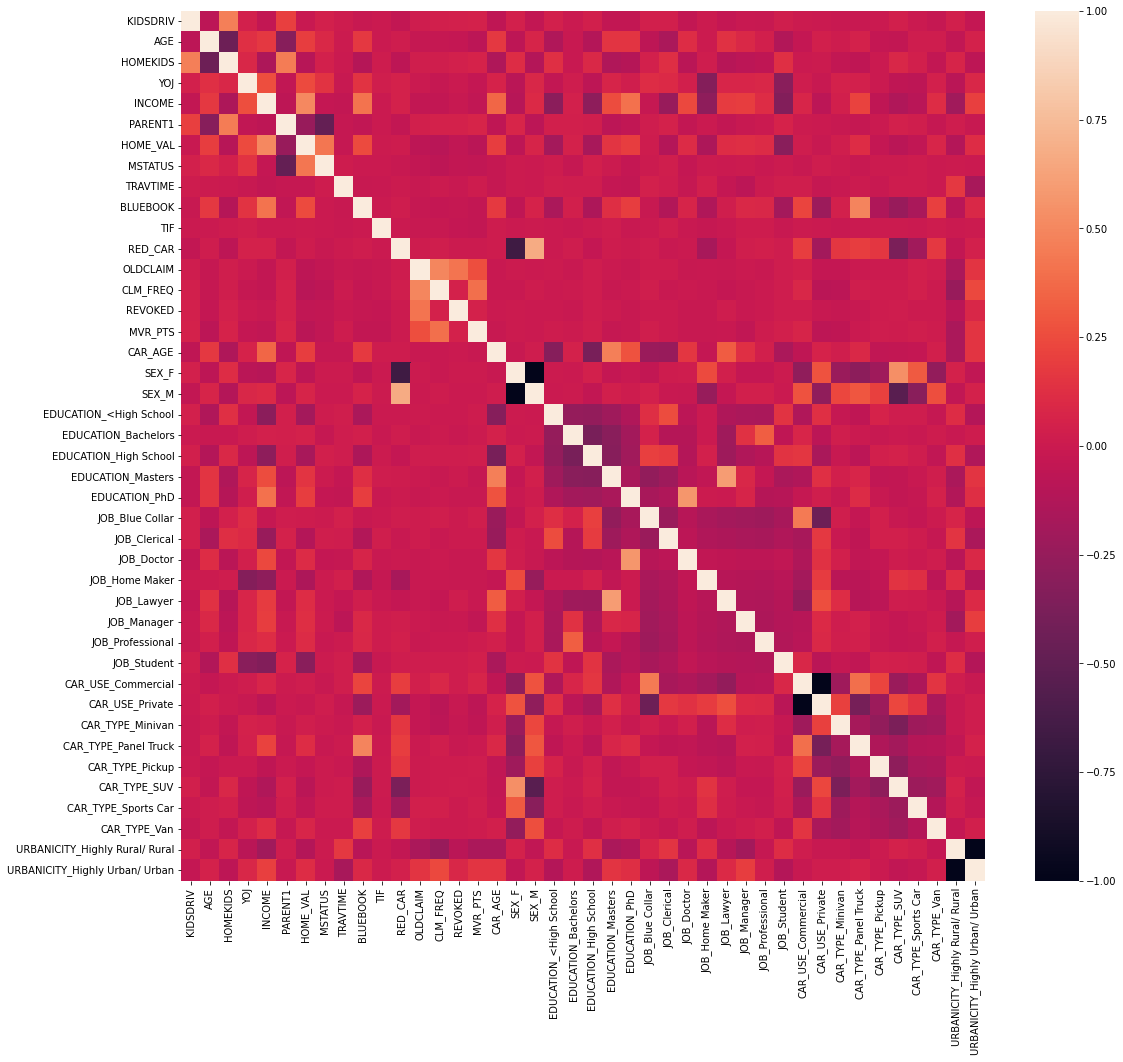

In [129]:
plt.figure(figsize=(18,16))
sns.heatmap(train_dataset.corr(),annot=False)

# Training the model

## Best Model Evaluation

In [130]:
metrics = ["accuracy","recall","f1","precision"]

In [131]:
# Try random Forest Classifier
model = RandomForestClassifier(n_estimators=100,max_depth=10)

scores = cross_validate(model, train_dataset,labels,cv=5,scoring = metrics)
scores = pd.DataFrame(scores).mean()
scores

fit_time          0.980422
score_time        0.054144
test_accuracy     0.784219
test_recall       0.316335
test_f1           0.435437
test_precision    0.701945
dtype: float64

We see that the recall is quite low. 

In [132]:
# Try with SVC
model = SVC()

scores = cross_validate(model, train_dataset,labels,cv=5 ,scoring = metrics)
scores = pd.DataFrame(scores).mean()
scores

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


fit_time          2.901907
score_time        0.686125
test_accuracy     0.736184
test_recall       0.000000
test_f1           0.000000
test_precision    0.000000
dtype: float64

In [133]:
# Try with KNeighborsClassifier
model = KNeighborsClassifier()

scores = cross_validate(model, train_dataset,labels,cv=5 ,scoring = metrics)
scores = pd.DataFrame(scores).mean()
scores

fit_time          0.006766
score_time        0.319358
test_accuracy     0.703345
test_recall       0.219689
test_f1           0.280600
test_precision    0.389078
dtype: float64

In [134]:
# Try with HistGradientBoostingClassifier
model= HistGradientBoostingClassifier()

scores = cross_validate(model, train_dataset,labels,cv=5 ,scoring = metrics)
scores = pd.DataFrame(scores).mean()
scores

fit_time          0.883461
score_time        0.022971
test_accuracy     0.792183
test_recall       0.463552
test_f1           0.540094
test_precision    0.648872
dtype: float64

In [135]:
# Try with GaussianNB
model = GaussianNB()

scores = cross_validate(model, train_dataset,labels,cv=5 ,scoring = metrics)
scores = pd.DataFrame(scores).mean()
scores

fit_time          0.011442
score_time        0.008318
test_accuracy     0.731895
test_recall       0.208539
test_f1           0.290727
test_precision    0.481316
dtype: float64

In [136]:
model= RidgeClassifier()

scores = cross_validate(model, train_dataset,labels,cv=5 ,scoring = metrics)
scores = pd.DataFrame(scores).mean()
scores

fit_time          0.017142
score_time        0.010235
test_accuracy     0.787159
test_recall       0.358579
test_f1           0.470526
test_precision    0.685119
dtype: float64

In [137]:
model = LogisticRegression()

scores = cross_validate(model, train_dataset,labels,cv=5 ,scoring = metrics)
scores = pd.DataFrame(scores).mean()
scores

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


fit_time          0.163182
score_time        0.010875
test_accuracy     0.735449
test_recall       0.065478
test_f1           0.113060
test_precision    0.475950
dtype: float64

# Fitting on the test dataset

In [138]:
model = HistGradientBoostingClassifier()
model.fit(train_dataset,labels)

HistGradientBoostingClassifier()

In [139]:
percentage_of_empty_values= (test_dataset.isna().sum().sum())/test_dataset.size *100
percentage_of_empty_values

0.5115544583083116

In [140]:
test_dataset_full = imputer.transform(test_dataset)
test_dataset= pd.DataFrame(test_dataset_full,columns=test_dataset.columns)

In [141]:
test_labels = model.predict(test_dataset)

In [142]:
print(100. * test_labels.sum() / test_labels.size)
print(100. * labels.sum() / labels.size)

18.5894441849603
26.381570885920844


# Explicabilité 

In [143]:
features = train_dataset.columns
features

Index(['KIDSDRIV', 'AGE', 'HOMEKIDS', 'YOJ', 'INCOME', 'PARENT1', 'HOME_VAL',
       'MSTATUS', 'TRAVTIME', 'BLUEBOOK', 'TIF', 'RED_CAR', 'OLDCLAIM',
       'CLM_FREQ', 'REVOKED', 'MVR_PTS', 'CAR_AGE', 'SEX_F', 'SEX_M',
       'EDUCATION_<High School', 'EDUCATION_Bachelors',
       'EDUCATION_High School', 'EDUCATION_Masters', 'EDUCATION_PhD',
       'JOB_Blue Collar', 'JOB_Clerical', 'JOB_Doctor', 'JOB_Home Maker',
       'JOB_Lawyer', 'JOB_Manager', 'JOB_Professional', 'JOB_Student',
       'CAR_USE_Commercial', 'CAR_USE_Private', 'CAR_TYPE_Minivan',
       'CAR_TYPE_Panel Truck', 'CAR_TYPE_Pickup', 'CAR_TYPE_SUV',
       'CAR_TYPE_Sports Car', 'CAR_TYPE_Van', 'URBANICITY_Highly Rural/ Rural',
       'URBANICITY_Highly Urban/ Urban'],
      dtype='object')

In [144]:
import shap
train = shap.sample(train_dataset,1000)

[[-0.07763275 -0.15255266 -0.01838118 ... -0.00251858  0.41250235
   0.02308771]
 [-0.08001088 -0.22638234  0.00749859 ... -0.00495877  0.35038349
   0.02377256]
 [-0.07847728 -0.11641943  0.0566073  ... -0.01854352  0.46374643
   0.0209823 ]
 ...
 [-0.10599711  0.09115284 -0.02541631 ... -0.00144273  0.3870777
   0.0231925 ]
 [-0.04324444 -0.02518914  0.00100589 ... -0.0024488   0.33912552
   0.03132778]
 [-0.03874802 -0.26743304 -0.00870532 ... -0.00525625  0.38303942
   0.01722451]]


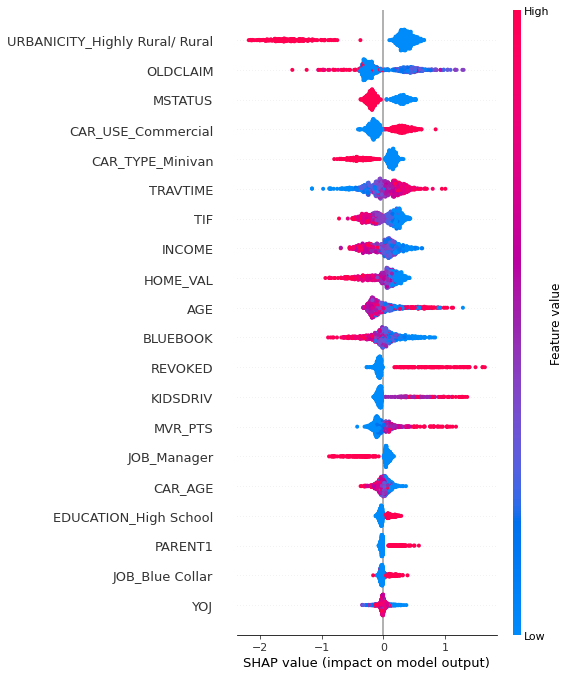

In [145]:
explainer = shap.Explainer(model)

shap_values = explainer.shap_values(train)
print(shap_values)
shap.summary_plot(shap_values, train)


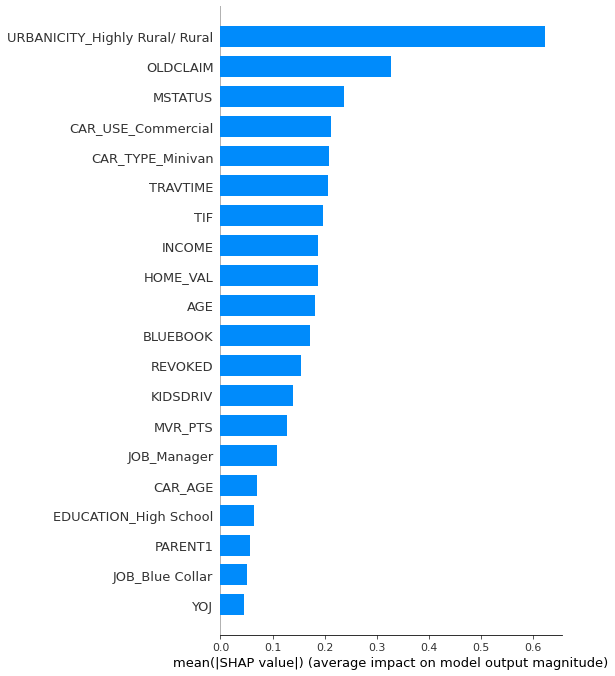

In [146]:
#Here we can see the most important features for prediction
shap.summary_plot(shap_values, train, feature_names=features, plot_type="bar")